# Weight perturbation implementation in python 

We will be using the iris dataset for this! Let us look at how the dataset looks like...before that lets import the libraries required.

In [11]:
import pandas as pd
import numpy as np
import random
from typing import List, Callable
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Reading the dataset

In [20]:
#df stores the dataframe
df = pd.read_csv("C:\\Users\\Rohit\\Desktop\\Perturbation Techniques in CNNs\\Perturbation-techniques-in-CNNs\\data\\Iris.csv")

Let us see how our dataset looks like...

In [21]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


So it has 1 redundant column 'Id' which we will drop, 4 feature columns and finally the target variable viz 'Species'

Further, we want to sample the rows at random for our train and test datasets hence, we reorder the rows randomly as done below.

In [22]:
#reordering so that we sample our train and test dataset randomly
df = df.sample(frac = 1)
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
70,71,5.9,3.2,4.8,1.8,Iris-versicolor
43,44,5.0,3.5,1.6,0.6,Iris-setosa
105,106,7.6,3.0,6.6,2.1,Iris-virginica
71,72,6.1,2.8,4.0,1.3,Iris-versicolor
114,115,5.8,2.8,5.1,2.4,Iris-virginica
...,...,...,...,...,...,...
111,112,6.4,2.7,5.3,1.9,Iris-virginica
123,124,6.3,2.7,4.9,1.8,Iris-virginica
110,111,6.5,3.2,5.1,2.0,Iris-virginica
60,61,5.0,2.0,3.5,1.0,Iris-versicolor


In [23]:
#dropping the 'Id' column
#df = df.drop(["Id"], axis = 1)
#df

## Extracting the train and test datasets

In [24]:
#endocing the target variable
y = df.Species.replace({"Iris-setosa" : 0, "Iris-virginica" : 1, "Iris-versicolor":2})
y

70     2
43     0
105    1
71     2
114    1
      ..
111    1
123    1
110    1
60     2
51     2
Name: Species, Length: 150, dtype: int64

In [25]:
X = df.iloc[:, 1:5]

Further, we must normalise all the feature columns!

In [26]:
X = normalize(X,axis=0)
#X = np.c_[X, np.ones(X.shape[0])]
X

array([[0.08163129, 0.08470916, 0.09444501, 0.10352695],
       [0.06917906, 0.09265065, 0.03148167, 0.03450898],
       [0.10515217, 0.07941484, 0.12986189, 0.12078145],
       [0.08439845, 0.07412052, 0.07870418, 0.07476947],
       [0.08024771, 0.07412052, 0.10034783, 0.13803594],
       [0.07194622, 0.09265065, 0.02951407, 0.01150299],
       [0.09408352, 0.07412052, 0.09444501, 0.08052096],
       [0.06502832, 0.08470916, 0.02557886, 0.01150299],
       [0.09269994, 0.082062  , 0.0865746 , 0.08052096],
       [0.09685068, 0.08470916, 0.09247741, 0.08052096],
       [0.09961785, 0.08470916, 0.11805627, 0.10352695],
       [0.0954671 , 0.082062  , 0.09641262, 0.08627246],
       [0.08993278, 0.07412052, 0.0905098 , 0.08627246],
       [0.08578203, 0.07412052, 0.09444501, 0.10352695],
       [0.06087757, 0.07941484, 0.02557886, 0.01150299],
       [0.06779548, 0.06353187, 0.06493095, 0.05751497],
       [0.07056264, 0.09794497, 0.02951407, 0.02300599],
       [0.08716562, 0.07676768,

We have finished prepocessing our dataset!

In [27]:
X_train, y_train, X_test, y_test = X[:130, :], y[:130], X[130:, :], y[130:]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
y_train

82     2
99     2
0      0
74     2
46     0
      ..
128    1
145    1
38     0
127    1
35     0
Name: Species, Length: 135, dtype: int64

## Defining the architecture of our neural network

In [30]:
def initialise(neuron_no, H):
  """returns a list containing np arrays of weights at each synpase

  Args:
      neuron_no (list): List of integers which represent the number of neurons at each layer
      H (int): The total depth of the neural network

  Returns:
      List: a list containing np arrays of weights at each synpase
  """
  assert len(neuron_no)==H+1
  W = []
  b = []
  for i in range(0, H):
    W.append(np.random.rand(neuron_no[i]+1, neuron_no[i+1]))
  #for i in range(1, H+1):
  #  b.append(np.random.rand(neuron_no[i],1))
  return W

### Defining the feedforward path

In [31]:
Array_Function = Callable[[np.ndarray], np.ndarray]
# A Chain is a list of functions
Chain = List[Array_Function]

In [ ]:
def ForwardPass(chain: Chain, W, input : np.ndarray) ->np.ndarray:
  f1 = chain[0] #first activation function
  f2 = chain[1]
  f3 = chain[2]
  z1 = np.dot(W[0].T, np.r_[input, [np.ones(input.shape[1])]])
  a1 = f1(z1)
  
  a1 = np.r_[a1, [np.ones(a1.shape[1])]]
  #print(a1.shape)
  z2 = np.matmul(W[1].T, a1)
  a2 = f2(z2)
  #print(a2.shape)
  a2 = np.r_[a2, [np.ones(a2.shape[1])]]
  z3 = np.dot(W[2].T, a2)
  #print(z3.shape)
  o = f3(z3)
  return o

In [ ]:
def ForwardPassgen(chain: Chain, W, input : np.ndarray, H) -> np.ndarray:
    z1 = input
    for i in range(0, H):
        activation = chain[i]
        a1 = activation(np.dot(W[i].T, np.r_[z1, [np.ones(z1.shape[1])]]))
        z1 = a1
    return z1

### Defining our loss functions

In [ ]:
def cross_entropy(target:np.ndarray, predicted) ->float:
    """Calculates and returns the cross entropy loss given the predicted values 
        from our model and the actual target values

    Args:
        target (np.ndarray): one hot encoded target values from the dataset
        predicted ([type]): values predicted from our neural network

    Returns:
        float: The cross entropy loss 
    """
    loss = []
    #notice that target has 3 values in each row same as predicted!
    for i in range(0, len(target)):
        loss.append(np.matmul(target[i, :], np.log(1e-15 + predicted[:, i])))#to prevent 0 calculation!
    return -np.sum(np.array(loss))/len(loss)

In [ ]:
def indicator(x : np.ndarray, y: np.ndarray) -> np.ndarray :
    """Basically calcuates the similarity between 2 arrays - 
    
    spikes only when 2 corresponding values are equal. The sum of its elements would
    
    give us the number of elements which are equal in the 2 arrays

    Args:
        x (np.ndarray): an array
        y (np.ndarray): an array

    Returns:
        np.ndarray: similarity array of the same size as x or y with 0's and 1's
    """
    assert len(x)==len(y)
    return np.array([1 if x[i]==y[i] else 0 for i in range(0, len(x))])

In [ ]:
def accuracy(target : np.ndarray, predicted : np.ndarray) -> float:
    """Returns the accuracy = correct prediction divided by total predictions made

    Args:
        target (np.ndarray): target values from the dataset
        predicted (np.ndarray): the values which are prdicted having the highest probability

    Returns:
        float: accuracy of the prediction made
    """
    #acc = np.sum(indicator(target, predicted))/len(target)
    #acc = 1.0/len(target)*np.sum(target == predicted)
    acc = 1.0/len(target)*confusion_matrix(target, predicted).trace()
    return acc

In [ ]:
def one_hot(y:np.ndarray, len_hot) -> np.ndarray:
  shape = (y.size, len_hot)
  one_hot_encode = np.zeros(shape)
  row_index = np.arange(y.size)
  one_hot_encode[row_index, y] = 1
  return one_hot_encode

### Defining the activation functions

In [ ]:
def relu(x : np.ndarray) -> np.ndarray:
  return np.maximum(0, x)

In [ ]:
def softmax(x : np.ndarray) -> np.ndarray:
  e_x = np.exp(x - np.max(x))
  return e_x/e_x.sum(axis = 0)

### Calculating the perturbation and training functions!

In [ ]:
def ApplyPert(W:List, pert, k, i,j):
  W[k][i, j] +=pert
  return W

In [ ]:
def calc_gradients(W, pert, X_train,y_train):#UPDATE!!
  gradients = initialise([4, 3, 5, 3], 3)
  for k in range(0,len(W)):
    for i in range(0, W[k].shape[0]):
      for j in range(0, W[k].shape[1]):
        Dw = ApplyPert(W, pert, k, i, j)
        h_calc = ForwardPass(chain, Dw, np.array(X_train).T)
        loss2 = cross_entropy(one_hot(np.array(y_train)), h_calc)
        grad = (loss2 - loss1)/pert
        gradients[k][i, j] = grad
  return gradients

In [ ]:
def train_my_model(N, H, epochs:int, chain:Chain, X_train:np.ndarray, y_train, X_test:np.ndarray, y_test, pert, lr, reg_lam):
  W = initialise(N, H)
  loss_arr = []
  loss_test_arr = []
  acc_arr = []
  acc_test_arr = []
  for i in range(0, epochs):
    print("Training EPoch ---- ", i, " -----")
    output = ForwardPass(chain, W, np.array(X_train).T)
    #loss = cross_entropy(one_hot(np.array(y_train), output.shape[0]), output) + (reg_lam/(2*len(y_train)))*(np.sum(np.array([np.sum(W[i]**2) for i in range(0, H)])))
    loss = log_loss(y_train, output.T)/len(y_train)
    loss_arr.append(loss)
    #acc_arr.append(accuracy(np.array(y_train) ,output.argsort(axis = 0)[-1, :]))
    acc_arr.append(accuracy(np.array(y_train) ,np.argmax(output, axis = 0)))
    output_test = ForwardPass(chain, W, np.array(X_test).T)
    #loss_test_arr.append(cross_entropy(one_hot(np.array(y_test), output.shape[0]), output_test))
    loss_test_arr.append(log_loss(one_hot(np.array(y_test), output_test.shape[0]), output_test.T)/len(y_test))
    #acc_test_arr.append(accuracy(np.array(y_test) ,output_test.argsort(axis = 0)[-1, :]))
    acc_test_arr.append(accuracy(np.array(y_test) ,np.argmax(output_test, axis = 0)))
    print("Loss epoch ", i, " is = ", loss)
    print("---------------------------------")
    gradients = initialise(N, H)
    for k in range(0,len(W)):
      print("Started ", k, " -------------")
      for i in range(0, W[k].shape[0]):
        for j in range(0, W[k].shape[1]):
          Dw = ApplyPert(W, pert, k, i, j)
          output_pert = ForwardPass(chain, Dw, np.array(X_train).T)
          #loss_pert = cross_entropy(one_hot(np.array(y_train), output.shape[0]), output_pert)
          loss_pert = log_loss(one_hot(np.array(y_train), output_pert.shape[0]), output_pert.T)/len(y_train)
          grad = (loss_pert - loss)/pert
          gradients[k][i, j] = grad
    for i in range(0, len(W)):
      W[i] += (-lr*gradients[i])
      #W[i] += (lr*gradients[i])
  return loss_arr, acc_arr, acc_test_arr, W, output, loss_test_arr, output

In [ ]:
from intertools import permutations
def train_my_model_par(N, H, epochs:int, chain:Chain, X_train:np.ndarray, y_train, X_test:np.ndarray, y_test, pert, lr):
  W = initialise(N, H)
  loss_arr = []
  loss_test_arr = []
  acc_arr = []
  acc_test_arr = []
  for i in range(0, epochs):
    print("Training EPoch ---- ", i, " -----")
    output = ForwardPassgen(chain, W, np.array(X_train).T, H)
    loss = cross_entropy(one_hot(np.array(y_train)), output)
    loss_arr.append(loss)
    #acc_arr.append(accuracy(np.array(y_train) ,output.argsort(axis = 0)[-1, :]))
    acc_arr.append(accuracy(np.array(y_train) ,np.argmax(output, axis = 0)))
    output_test = ForwardPassgen(chain, W, np.array(X_test).T, H)
    loss_test_arr.append(cross_entropy(one_hot(np.array(y_test)), output_test))
    acc_test_arr.append(accuracy(np.array(y_test) ,output_test.argsort(axis = 0)[-1, :]))
    print("Loss epoch ", i, " is = ", loss)
    print("---------------------------------")
    gradients = initialise(N, H)
    pool_obj = mp.Pool(mp.cpu_count)
    results = [pool_obj.apply(calc_grad_par, args = () for g in list(permutation(range)))]
    pool_obj.close
    #for k in range(0,len(W)):
    #  print("Started ", k, " -------------")
    #  for i in range(0, W[k].shape[0]):
    #    for j in range(0, W[k].shape[1]):
    #      Dw = ApplyPert(W, pert, k, i, j)
    #      output_pert = ForwardPassgen(chain, Dw, np.array(X_train).T, H)
    #      loss_pert = cross_entropy(one_hot(np.array(y_train)), output_pert)
    #      grad = (loss_pert - loss)/pert
    #      gradients[k][i, j] = grad
    for i in range(0, len(W)):
      W[i] += (-lr*gradients[i])
      #W[i] += (lr*gradients[i])
  return loss_arr, acc_arr, acc_test_arr, W, output, loss_test_arr, output

SyntaxError: invalid syntax (<ipython-input-204-527ee336886c>, line 22)

In [ ]:
def calc_grad_par(W, chain:Chain, X_train:np.ndarray, y_train, X_test:np.ndarray, y_test, pert, lr, g, loss):
#g = (k, i, j)
    Dw = ApplyPert(W, pert, g[0], g[1], g[2])
    output_pert = ForwardPassgen(chain, Dw, np.array(X_train).T, H)
    loss_pert = cross_entropy(one_hot(np.array(y_train)), output_pert)
    grad = (loss_pert - loss)/pert
    return grad

In [ ]:
N = [4,2, 2, 3]
H = len(N)-1
W = initialise(N, H)

In [ ]:
chain = [relu, relu, softmax]

In [ ]:
z1 = np.dot(W[0].T, np.r_[X_train.T, [np.ones((X_train.T).shape[1])]])
z1

array([[0.99808041, 1.02580897, 0.96029844, 0.97592699, 1.02150158,
        0.9131943 , 1.00215707, 0.92487422, 1.01778248, 1.04075317,
        1.02672183, 1.00652522, 1.03445493, 0.91391063, 0.91270422,
        0.91300073, 0.94017923, 0.98891124, 0.91613141, 0.90918194,
        1.00215394, 0.99250094, 0.91919791, 0.91835054, 0.9223332 ,
        1.00186232, 0.99589559, 0.99468576, 0.93114002, 0.92278733,
        0.95341435, 0.99138989, 1.00936725, 0.98711653, 1.05044224,
        0.97501396, 1.03474643, 0.98499766, 0.91786045, 1.03008   ,
        0.96153905, 0.91737037, 0.9202421 , 0.93215155, 0.94421292,
        1.0000345 , 0.91818684, 0.91286644, 0.92878837, 0.97207685,
        0.9174032 , 0.97243726, 1.04894216, 0.91117171, 0.97896065,
        1.00195917, 0.92846648, 1.00081961, 1.00186232, 0.95644654,
        0.98369304, 1.02940015, 0.96548466, 0.93388059, 0.94626983,
        1.00714647, 0.91492335, 0.91241067, 0.95781859, 1.00303698,
        0.90895229, 1.02160019, 0.91675089, 0.93

In [ ]:
output = ForwardPassgen(chain, W, np.array(X_train).T, H)

In [ ]:
output

array([[0.31922976, 0.31822061, 0.32015445, 0.31975474, 0.31826647,
        0.3217399 , 0.31893982, 0.32142334, 0.31841377, 0.31832981,
        0.31814699, 0.31884505, 0.31803489, 0.32163382, 0.32174525,
        0.32178861, 0.32133483, 0.31956811, 0.32172072, 0.32178766,
        0.31881508, 0.31940842, 0.32171435, 0.32172492, 0.32181108,
        0.3187996 , 0.31925645, 0.31938174, 0.32141046, 0.32169235,
        0.32033829, 0.31936504, 0.31884375, 0.31957918, 0.31766886,
        0.31978605, 0.31823066, 0.31944763, 0.32173028, 0.31837841,
        0.32025251, 0.32173563, 0.32160038, 0.32134844, 0.32041161,
        0.31895886, 0.32168142, 0.32174778, 0.32126962, 0.31980534,
        0.32172535, 0.31992446, 0.31800105, 0.32176892, 0.31975867,
        0.31868505, 0.32166175, 0.31895587, 0.3187996 , 0.32030106,
        0.31945331, 0.31810171, 0.31986743, 0.321358  , 0.32041329,
        0.31875608, 0.32174945, 0.32178382, 0.32017867, 0.31905654,
        0.32190127, 0.31805505, 0.32172818, 0.32

In [ ]:
log_loss(np.array([0, 1, 2]), np.array([[0.5, 0.5, 0.0], [0.5, 0.4, 0.1], [0.4, 0.1, 0.5]]), labels = [0, 1, 2])

0.767528364331349

In [ ]:
loss = cross_entropy(one_hot(np.array(y_train), output.shape[0]), output)/len(y_train)
loss

0.008349387221111141

In [ ]:
np.matmul(np.array([1, 0, 0]), np.log(1e-15 + np.array([1, 0.0, 0.0])))

1.110223024625156e-15

In [ ]:
log_loss(y_train, output.T)/len(y_train)

0.008349387221111164

In [ ]:
epochs = 1000
lr = 0.0001
delta = 0.0001
reg_lam = 0.001

In [ ]:
fin_loss, fin_acc, fin_acc_test, fin_W, fin_op, fin_loss_test, out = train_my_model(N, H,epochs, chain, X_train, y_train, X_test, y_test, delta, lr, reg_lam);

Training EPoch ----  0  -----
Loss epoch  0  is =  0.008566888727802285
---------------------------------
Started  0  -------------
Started  1  -------------
Started  2  -------------
Training EPoch ----  1  -----
Loss epoch  1  is =  0.008567069459223992
---------------------------------
Started  0  -------------
Started  1  -------------
Started  2  -------------
Training EPoch ----  2  -----
Loss epoch  2  is =  0.00856725025703658
---------------------------------
Started  0  -------------
Started  1  -------------
Started  2  -------------
Training EPoch ----  3  -----
Loss epoch  3  is =  0.00856743112125475
---------------------------------
Started  0  -------------
Started  1  -------------
Started  2  -------------
Training EPoch ----  4  -----
Loss epoch  4  is =  0.008567612051893193
---------------------------------
Started  0  -------------
Started  1  -------------
Started  2  -------------
Training EPoch ----  5  -----
Loss epoch  5  is =  0.008567793048966607
----------

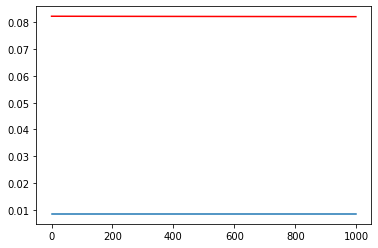

In [ ]:
x = np.arange(epochs)
plt.plot(x, fin_loss)
plt.plot(x, fin_loss_test, "r")

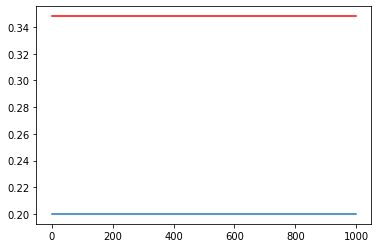

In [ ]:
plt.plot(x, fin_acc, "r")
plt.plot(x, fin_acc_test)

In [ ]:
y_train

56     2
104    1
69     2
55     2
132    1
      ..
71     2
106    1
14     0
92     2
102    1
Name: Species, Length: 135, dtype: int64

## Training MNIST dataset

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape,y.shape)

(70000, 784) (70000,)


In [ ]:
y[1]

'0'

In [ ]:
y_data = y.astype('int') #convert output to integers 0-9
X_data = X/255.0

In [ ]:
X_data.shape

(70000, 784)

In [ ]:
y_data


array([5, 0, 4, ..., 4, 5, 6])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42) #split the data into train and validation
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)


In [ ]:
#X_train = X_train.T
#X_val = X_val.T

In [ ]:
print(X_train.shape, X_val.shape)

(63000, 784) (7000, 784)


In [ ]:
N = [784, 50, 10]
H = len(N)-1
W = initialise(N, H)

In [ ]:
chain = [relu, softmax]

In [ ]:
epochs = 500
lr = 0.5
delta = 0.001

In [ ]:
fin_loss, fin_acc, fin_acc_test, fin_W, fin_op, fin_loss_test, out = train_my_model(N, H,epochs, chain, X_train, y_train, X_val, y_val, delta, lr);

Training EPoch ----  0  -----
Loss epoch  0  is =  6.164257768858461
---------------------------------
Started  0  -------------


KeyboardInterrupt: 

In [ ]:
import multiprocessing as mp

In [ ]:
print(mp.cpu_count())

12
